# Naive Bayes y CART Models

**Introducción:**
A menudo se enseña como una "caja negra" donde entran datos y salen predicciones. Hoy abriremos esa caja. Empezaremos calculando probabilidades a mano, entenderemos la matemática interna de los árboles de decisión y terminaremos demostrando una verdad fundamental en la industria: la calidad de los datos importa más que la complejidad del algoritmo.

### Tabla de Contenidos
1.  **Configuración Inicial:** Librerías y entorno.
2.  **Carga de Datos:** Preparación y simulación de variables sucias.
3.  **Intuición Probabilística:** ¿Por qué el modelo aprende? (Independencia Estadística).
4.  **Fundamentos Teóricos:**
    * 4.1 La Matemática del Árbol (Gini Manual).
    * 4.2 Geometría de los Modelos (Visualización de Fronteras - CORREGIDO).
    * 4.3 Intermedio Teórico (Gini vs Entropía).
    * 4.4 El Enfoque Probabilístico (Naive Bayes y sus parámetros).
5.  **El Gran Experimento:** Data-Centric vs Model-Centric.
    * 5.1 Baseline (Punto de partida).
    * 5.2 Model-Centric (Tuning Limitado).
    * 5.3 Data-Centric (Ingeniería de Características + Modelo Liberado).
6.  **Conclusiones:** Resultados y reflexiones finales.

---



### 1. Importación de Librerías y Configuración
**¿Por qué hacemos esto?**
Antes de empezar, necesitamos nuestras herramientas.
* `pandas` y `numpy`: Para manipular la estructura de datos (DataFrames).
* `seaborn` y `matplotlib`: Para visualizar lo que está ocurriendo.
* `sklearn`: Nuestra caja de herramientas de Machine Learning. Traemos modelos específicos (Árboles, Regresión Logística, Bayes) y utilidades para medir su rendimiento.

También configuramos el estilo visual para que los gráficos sean legibles en una presentación.



In [ ]:
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Configuración visual para docencia
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)
pd.set_option('display.max_columns', None)

def print_header(text):
    """Ayuda visual para separar secciones en la salida de la consola"""
    print("\n" + "=" * 80 + f"\n {text.upper()}\n" + "=" * 80)

print("Librerías cargadas correctamente. Entorno listo.")



Librerías cargadas correctamente. Entorno listo.


### 2. Carga y Preparación de Datos
**Contexto:**
Usaremos el famoso dataset del Titanic. Normalmente, los datasets de práctica vienen muy limpios. Sin embargo, para enseñar **Feature Engineering** (Ingeniería de Características) más adelante, necesitamos acceso a datos "crudos" como el Nombre o el Ticket, que contienen información oculta.

**Decisión Técnica:**
Como el dataset por defecto de `seaborn` no trae los Nombres ni los Tickets originales, vamos a **simularlos** sintéticamente.
* Generamos `ticket_fake` combinando tarifa y clase (personas con mismo ticket suelen viajar juntas).
* Generamos `name_fake` añadiendo títulos (Mr, Mrs, Master) basados en edad y sexo.

Esto nos permitirá demostrar luego cómo extraer valor de columnas de texto que parecen inútiles. También llenamos nulos en la edad para no perder datos.



In [ ]:
# Cargar dataset base
df = sns.load_dataset('titanic')

# --- SIMULACIÓN DE DATOS RAW (Para el ejercicio final) ---
# Nota Pedagógica: En un proyecto real, estas columnas ya existen.
# Aquí las recreamos para poder hacer el ejercicio de Feature Engineering luego.
np.random.seed(42)

def simular_nombre(row):
    # Asignamos títulos lógicos basados en reglas demográficas
    if row['sex'] == 'female':
        title = 'Miss.' if row['age'] < 18 else 'Mrs.'
    else:
        title = 'Master.' if row['age'] < 16 else 'Mr.'
    return f"Simulated Name, {title} John"

# Creamos variables compuestas
df['ticket_fake'] = df['fare'].astype(str) + "_" + df['pclass'].astype(str) # Tickets compartidos
df['name_fake'] = df.apply(simular_nombre, axis=1) # Nombres con títulos

# Limpieza básica
# Llenamos la edad con la mediana para no perder filas, y borramos filas sin tarifa
df['age'] = df['age'].fillna(df['age'].median())
df.dropna(subset=['fare', 'embarked'], inplace=True)

# Seleccionamos variables iniciales
print_header("VISTA PREVIA DE LOS DATOS")
print("Observa las columnas 'name_fake' y 'ticket_fake' que usaremos al final.")
print(df.head())




 VISTA PREVIA DE LOS DATOS
Observa las columnas 'name_fake' y 'ticket_fake' que usaremos al final.
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone ticket_fake  \
0    man        True  NaN  Southampton    no  False      7.25_3   
1  woman       False    C    Cherbourg   yes  False   71.2833_1   
2  woman       False  NaN  Southampton   yes   True     7.925_3   
3  woman       False    C  Southampton   yes  False      53.1_1   
4    man        True  NaN  Southampton    no   True      8.05_3   

                   name_fake  
0   Simul

### 3. La Intuición: Probabilidad Condicional
**¿Para qué sirve esto?**
Antes de lanzar algoritmos complejos, debemos usar el sentido común (Estadística Descriptiva).
El aprendizaje automático se basa en encontrar variables que **reduzcan la incertidumbre**.

Si $P(Sobrevivir) = 38\%$, pero $P(Sobrevivir | Mujer) = 74\%$, entonces saber el genero reduce drásticamente mi incertidumbre. Si estas dos probabilidades fueran iguales, la variable "genero" no serviría para nada (sería independiente).




 ANÁLISIS DE PROBABILIDAD
Probabilidad base de sobrevivir (sin saber nada más): 38.25%
Probabilidad dado que es Mujer:  74.04%
Probabilidad dado que es Hombre: 18.89%


/tmp/ipython-input-1482648536.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sex', y='survived', data=df, palette='viridis')


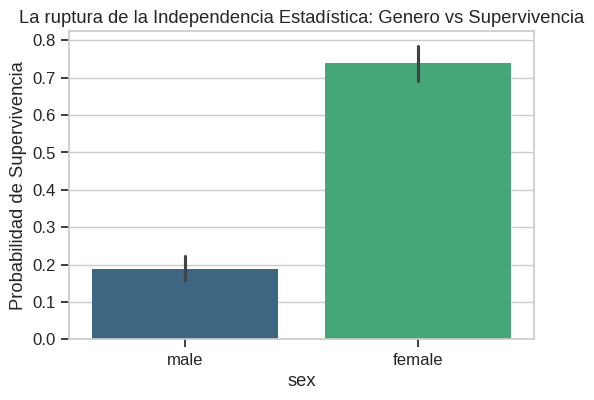

In [ ]:
print_header("ANÁLISIS DE PROBABILIDAD")

# Probabilidad Global (Priori)
p_surv = df['survived'].mean()
print(f"Probabilidad base de sobrevivir (sin saber nada más): {p_surv:.2%}")

# Probabilidad Condicionada (Posteriori)
probs_sex = df.groupby('sex')['survived'].mean()
print(f"Probabilidad dado que es Mujer:  {probs_sex['female']:.2%}")
print(f"Probabilidad dado que es Hombre: {probs_sex['male']:.2%}")

# Visualización
plt.figure(figsize=(6, 4))
sns.barplot(x='sex', y='survived', data=df, palette='viridis')
plt.title("La ruptura de la Independencia Estadística: Genero vs Supervivencia")
plt.ylabel("Probabilidad de Supervivencia")
plt.show()



### 4. Fundamentos de Modelado
Ahora pasamos a los modelos. Para poder comparar matemáticamente, primero debemos transformar nuestros datos a números (las computadoras no entienden "male" o "female").

**Acción:**
Usamos `LabelEncoder` para convertir Sexo en 0 y 1. Separamos en Train (Entrenamiento) y Test (Prueba) para asegurar una evaluación honesta.



In [ ]:
# Preparación de datos NUMÉRICOS básicos para la comparativa teórica
le = LabelEncoder()
df_math = df.copy()
df_math['sex_code'] = le.fit_transform(df_math['sex'])

# Variables simples para la demostración matemática
X_math = df_math[['pclass', 'sex_code', 'age', 'fare']]
y_math = df_math['survived']

X_train, X_test, y_train, y_test = train_test_split(X_math, y_math, test_size=0.3, random_state=42)

print("Datos preparados y divididos (70% Train, 30% Test).")



Datos preparados y divididos (70% Train, 30% Test).


#### 4.1 La Matemática del Árbol (Cálculo Manual de Gini)
**Concepto Clave:**
Un Árbol de Decisión no "adivina". Calcula. En cada paso, el árbol debe decidir qué pregunta hacer: *"¿Es hombre?"* o *"¿Es de tercera clase?"*.

Para decidir, usa una métrica llamada **Impureza de Gini**:
$$ Gini = 1 - \sum (p_i)^2 $$

* Si Gini es 0, el grupo es puro (todos sobrevivieron o todos murieron).
* Si Gini es 0.5, es el caos máximo (50/50).

**El experimento:** Vamos a calcular manualmente qué variable reduce más el caos (Gini): ¿El Genero o la Clase? La que reduzca más el caos (mayor Ganancia de Información) será la raíz del árbol.



In [ ]:
def calcular_gini(serie):
    """Calcula la impureza de Gini de una serie de datos."""
    counts = serie.value_counts(normalize=True)
    return 1 - sum(counts ** 2)

gini_root = calcular_gini(y_train)
print(f"Impureza Gini Inicial (Nodo Raíz - Caos inicial): {gini_root:.4f}")

# Simulamos el primer corte del árbol: ¿Es mejor dividir por Sexo o por Clase?

# OPCIÓN 1: Corte por SEXO
# Calculamos el Gini de los que son Mujeres y el Gini de los que son Hombres
gini_sex_L = calcular_gini(y_train[X_train['sex_code']==0]) # Mujeres
gini_sex_R = calcular_gini(y_train[X_train['sex_code']==1]) # Hombres
# Promedio ponderado por cantidad de gente en cada grupo
w_sex = len(y_train[X_train['sex_code']==0])/len(y_train)
gini_split_sex = w_sex*gini_sex_L + (1-w_sex)*gini_sex_R

# OPCIÓN 2: Corte por CLASE (Clase 1 vs Resto)
mask_class1 = X_train['pclass'] == 1
gini_pclass_L = calcular_gini(y_train[mask_class1])
gini_pclass_R = calcular_gini(y_train[~mask_class1])
w_class = len(y_train[mask_class1])/len(y_train)
gini_split_class = w_class*gini_pclass_L + (1-w_class)*gini_pclass_R

print_header("COMPETENCIA MATEMÁTICA (GANANCIA DE INFORMACIÓN)")
print(f"Si dividimos por GENERO, el Gini baja a:   {gini_split_sex:.4f} (Ganancia: {gini_root - gini_split_sex:.4f})")
print(f"Si dividimos por CLASE, el Gini baja a: {gini_split_class:.4f} (Ganancia: {gini_root - gini_split_class:.4f})")

if gini_split_sex < gini_split_class:
    print(">>> GANADOR: GENERO. El árbol pondrá esta pregunta en la cima porque ordena mejor los datos.")
else:
    print(">>> GANADOR: PCLASS")



Impureza Gini Inicial (Nodo Raíz - Caos inicial): 0.4739

 COMPETENCIA MATEMÁTICA (GANANCIA DE INFORMACIÓN)
Si dividimos por GENERO, el Gini baja a:   0.3368 (Ganancia: 0.1371)
Si dividimos por CLASE, el Gini baja a: 0.4431 (Ganancia: 0.0308)
>>> GANADOR: GENERO. El árbol pondrá esta pregunta en la cima porque ordena mejor los datos.


#### 4.2 Visualizando la diferencia geométrica (Lineal vs No Lineal)
**¿Por qué hacemos esto?**
A menudo es difícil entender la diferencia abstracta entre un Árbol y una Regresión Logística. Aquí vamos a graficar sus "cerebros".

Hemos ajustado la visualización para recortar los datos atípicos (Outliers) en el gráfico. Al hacer zoom en `Fare < 100`, filtramos también los puntos que se salen de ese rango para evitar que aparezcan "volando" fuera de la zona coloreada.




 VISUALIZACIÓN: CAJAS VS LÍNEAS


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


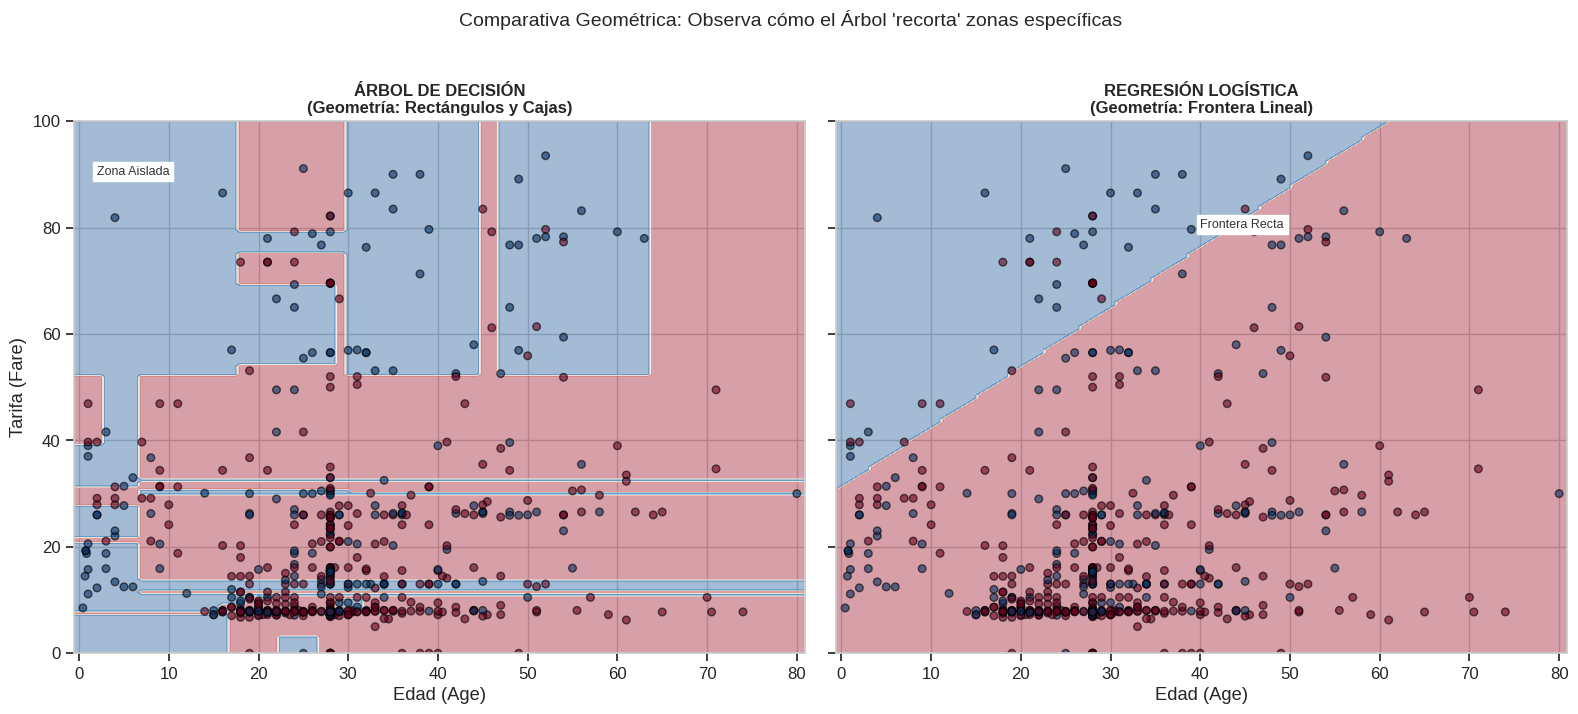

Interpretación Visual:
- Solo vemos los puntos relevantes (Fare < 100).
- Árbol: Fíjate en los 'escalones'. Puede crear reglas muy específicas.
- Logística: Es una línea recta/diagonal. No puede rodear grupos complejos.


In [ ]:
# Subconjunto 2D solo para visualización
X_viz = X_train[['age', 'fare']].copy()

# Entrenamos los dos modelos con estos datos limitados
# AUMENTAMOS EL MAX_DEPTH a 8 solo para esta gráfica para exagerar el efecto "rectángulo"
tree_viz = DecisionTreeClassifier(max_depth=8, random_state=42)
tree_viz.fit(X_viz, y_train)

scaler_viz = StandardScaler() # La regresión logística necesita datos escalados
X_viz_sc = scaler_viz.fit_transform(X_viz)
log_viz = LogisticRegression()
log_viz.fit(X_viz_sc, y_train)

# --- CÓDIGO DE PLOTEO (Malla de predicción) ---
print_header("VISUALIZACIÓN: CAJAS VS LÍNEAS")

# 1. Configuración de la Malla (Grid)
y_limit_viz = 100 # Límite visual para Fare (Zoom)
x_min, x_max = X_viz['age'].min() - 1, X_viz['age'].max() + 1
y_min, y_max = 0, y_limit_viz + 5 # Un poco de margen arriba
h = 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 2. Configuración del Gráfico
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 7))
cm = plt.cm.RdBu
cm_bright = plt.cm.RdBu

# --- FILTRO DE DATOS PARA EL SCATTER ---
# IMPORTANTE: Solo graficamos los puntos que "caben" en el zoom.
mask_viz = X_viz['fare'] <= y_limit_viz
X_viz_plot = X_viz[mask_viz]
y_train_plot = y_train[mask_viz]

# --- GRÁFICO A: ÁRBOL DE DECISIÓN ---
Z_tree = tree_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z_tree = Z_tree.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z_tree, cmap=cm, alpha=0.4)
# Usamos los datos filtrados (X_viz_plot)
axarr[0].scatter(X_viz_plot['age'], X_viz_plot['fare'], c=y_train_plot, cmap=cm_bright, edgecolors='k', s=30, alpha=0.6)

axarr[0].set_title("ÁRBOL DE DECISIÓN\n(Geometría: Rectángulos y Cajas)", fontsize=12, fontweight='bold')
axarr[0].set_ylabel('Tarifa (Fare)')
axarr[0].set_xlabel('Edad (Age)')
axarr[0].set_ylim(0, y_limit_viz) # Forzamos el límite Y para cortar lo que sobre
axarr[0].text(2, 90, "Zona Aislada", color='black', backgroundcolor='white', fontsize=9, alpha=0.8)

# --- GRÁFICO B: REGRESIÓN LOGÍSTICA ---
Z_log = log_viz.predict(scaler_viz.transform(np.c_[xx.ravel(), yy.ravel()]))
Z_log = Z_log.reshape(xx.shape)

axarr[1].contourf(xx, yy, Z_log, cmap=cm, alpha=0.4)
axarr[1].scatter(X_viz_plot['age'], X_viz_plot['fare'], c=y_train_plot, cmap=cm_bright, edgecolors='k', s=30, alpha=0.6)

axarr[1].set_title("REGRESIÓN LOGÍSTICA\n(Geometría: Frontera Lineal)", fontsize=12, fontweight='bold')
axarr[1].set_xlabel('Edad (Age)')
axarr[1].set_ylim(0, y_limit_viz) # Forzamos el límite Y
axarr[1].text(40, 80, "Frontera Recta", color='black', backgroundcolor='white', fontsize=9, alpha=0.8)

plt.suptitle("Comparativa Geométrica: Observa cómo el Árbol 'recorta' zonas específicas", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

print("Interpretación Visual:")
print("- Solo vemos los puntos relevantes (Fare < 100).")
print("- Árbol: Fíjate en los 'escalones'. Puede crear reglas muy específicas.")
print("- Logística: Es una línea recta/diagonal. No puede rodear grupos complejos.")



### 4.3 Intermedio Teórico: Conceptos Avanzados
Antes de pasar al experimento, aclaremos tres dudas técnicas fundamentales para entender qué estamos "moviendo" cuando ajustamos estos modelos.

**1. ¿Qué pasa si el Gini es 1? (La Trampa)**
Es imposible en este dataset. En clasificación **binaria** (0 o 1), el Gini máximo es **0.5**.
* Gini = 0.0: Orden Total (Todos vivos o Todos muertos).
* Gini = 0.5: Caos Máximo (50% vivos, 50% muertos). Cálculo: $1 - (0.5^2 + 0.5^2) = 0.5$.
* El Gini solo se acerca a 1 en problemas **multiclase** (ej: clasificar 1000 tipos de animales).

**2. ¿Gini vs Entropía (Entropy)?**
Los árboles pueden configurarse con `criterion='entropy'`.
* **Gini:** Mide probabilidad de error (Más rápido de calcular).
* **Entropía:** Mide "cantidad de información/sorpresa" (Usa logaritmos, más lento).
* **Veredicto:** En el 95% de los casos dan el mismo resultado. Gini es el estándar por velocidad.

**3. Hiperparámetros Críticos: Árboles vs Naive Bayes**
* **Árboles (Modelo Flexible):** Son como arcilla. Si no los limitas, se adaptan demasiado y memorizan ruido (*Overfitting*).
    * **Ajustar:** `max_depth` y `min_samples_leaf` (mínimo de gente para tomar una decisión) son VITALES.
* **Naive Bayes (Modelo Rígido):** Se basa en teoremas de probabilidad fijos.
    * **Ajustar:** Apenas tiene parámetros. Su fuerza viene de la teoría, no del ajuste fino. Funciona bien "out of the box".



In [ ]:
# Demostración rápida: Entropía vs Gini
tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
tree_entropy.fit(X_train, y_train)
acc_ent = accuracy_score(y_test, tree_entropy.predict(X_test))

# Comparamos con el árbol Gini que entrenaremos en el Baseline
print_header("GINI VS ENTROPY")
print(f"Accuracy usando Entropía: {acc_ent:.2%}")
print("Nota: Generalmente la diferencia es marginal (< 1%).")




 GINI VS ENTROPY
Accuracy usando Entropía: 82.40%
Nota: Generalmente la diferencia es marginal (< 1%).


### 4.4 El Enfoque Probabilístico: Naive Bayes

**Diccionario de Hiperparámetros (Naive Bayes):**
A diferencia de los árboles, Naive Bayes es paramétricamente simple y elegante.
* **¿Qué ajustamos?** Casi nada. No hay "profundidad" ni "hojas".
* **`var_smoothing`:** Es el único parámetro técnico común en `GaussianNB`.
    * *¿Qué significa?* Agrega una pequeñísima cantidad a la varianza de todas las características.
    * *¿Para qué sirve?* Para estabilidad numérica (evitar divisiones por cero) y para "suavizar" la curva de Gauss si hay muy pocos datos.
    * *Veredicto:* Raramente cambia el resultado de forma drástica.

**¿Por qué se llama "Naive" (Ingenuo)?**
Porque asume que **todas las variables son independientes**. Asume que la *Edad* no tiene nada que ver con la *Clase* o el *Precio*. Aunque es una mentira en el mundo real (en el Titanic los ricos pagaban más), el modelo funciona sorprendentemente bien.




 NAIVE BAYES ACCURACY: 77.15%


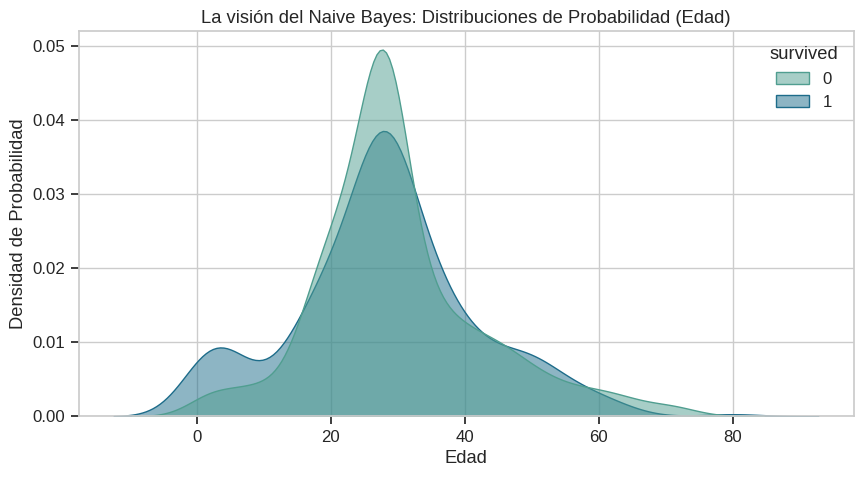

Interpretación: Si las campanas verde (vivió) y azul (murió) están muy separadas, Naive Bayes acertará mucho.
Si están superpuestas (como aquí), le costará decidir.


In [ ]:
# 1. Entrenamos el modelo Gaussian Naive Bayes
# Usamos "Gaussian" porque nuestras variables (Edad, Fare) son numéricas continuas
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 2. Predicción y Evaluación
y_pred_nb = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

print_header(f"NAIVE BAYES ACCURACY: {acc_nb:.2%}")

# 3. Visualización: ¿Qué "ve" Naive Bayes?
# Naive Bayes asume que los datos siguen una distribución normal (campana).
# Graficamos la distribución real para ver si esa asunción tiene sentido.
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='age', hue='survived', fill=True, common_norm=False, palette='crest', alpha=0.5)
plt.title("La visión del Naive Bayes: Distribuciones de Probabilidad (Edad)")
plt.xlabel("Edad")
plt.ylabel("Densidad de Probabilidad")
plt.show()

print("Interpretación: Si las campanas verde (vivió) y azul (murió) están muy separadas, Naive Bayes acertará mucho.\nSi están superpuestas (como aquí), le costará decidir.")



### 5. LA BATALLA FINAL: Data-Centric vs Model-Centric

Llegamos al núcleo de la lección. Queremos obtener la mejor precisión posible.

**El Baseline (Punto de Partida):**
Primero entrenamos un modelo estándar con los datos numéricos que tenemos, sin hacer nada especial. Esto nos da una métrica base para comparar. Si no tenemos un baseline, no sabemos si estamos mejorando.



In [ ]:
# --- 1. ESTABLECER BASELINE (Punto de partida) ---
# Usamos el árbol con configuración por defecto
tree_base = DecisionTreeClassifier(random_state=42)
tree_base.fit(X_train, y_train)
acc_base = accuracy_score(y_test, tree_base.predict(X_test))

print_header(f"ACCURACY BASELINE: {acc_base:.2%}")
print("Este es el número a vencer.")




 ACCURACY BASELINE: 76.40%
Este es el número a vencer.


#### 5.1 Estrategia Model-Centric (Tuning)
**La Hipótesis:** *"Si configuro mejor los parámetros del modelo, obtendré mejores resultados."*

**AJUSTE ESTRATÉGICO:**
Para esta demostración, seremos realistas. No dejaremos que el modelo memorice todo (Overfitting) usando profundidades infinitas.
Limitaremos la búsqueda a profundidades razonables (max_depth de 3 a 6). Esto simula un ingeniero prudente que quiere un modelo que generalice bien.



In [ ]:
# Definimos la rejilla de parámetros a probar
# NOTA: Quitamos profundidades extremas para evitar Overfitting "tramposo"
param_grid = {
    'criterion': ['gini', 'entropy'],       # Fórmula de corte
    'max_depth': [3, 4, 5, 6],              # Profundidad LIMITADA
    'min_samples_leaf': [1, 2, 4, 6],       # Robustez (Evitar overfitting)
    'class_weight': [None, 'balanced']      # Atención a desbalance
}

# Ejecutamos la búsqueda (Cross-Validation de 5 pliegues)
print("Iniciando GridSearch (Tuning)... esto puede tomar unos instantes.")
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
acc_tuned = accuracy_score(y_test, best_model.predict(X_test))

print(f"Mejores parámetros encontrados: {grid.best_params_}")
print(f"Accuracy tras Tuning: {acc_tuned:.2%}")
print(f"Mejora sobre Baseline: {acc_tuned - acc_base:.2%}")



Iniciando GridSearch (Tuning)... esto puede tomar unos instantes.
Mejores parámetros encontrados: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}
Accuracy tras Tuning: 81.65%
Mejora sobre Baseline: 5.24%


#### 5.2 Estrategia Data-Centric (Feature Engineering)
**La Hipótesis:**
*"El modelo no es el problema, los datos son el problema. Si le damos mejores variables que expliquen mejor el problema, el modelo aprenderá mejor."*

**La Acción:**
En lugar de tocar el algoritmo, tocamos los datos. Creamos variables de alto valor (`Title`, `Family Size`).

**AJUSTE ESTRATÉGICO:**
Dado que ahora tenemos datos de mucha más calidad y complejidad (matices sociales, familiares), **LIBERAMOS** la profundidad del árbol (subimos a `max_depth=10`). Un modelo inteligente con datos ricos necesita libertad para encontrar patrones sutiles.



In [ ]:
# Copiamos el dataframe para no romper el original
df_fe = df.copy()

# --- CREACIÓN DE VARIABLES (Feature Engineering) ---

# 1. Título: Extraemos la palabra antes del punto en el nombre
df_fe['title'] = df_fe['name_fake'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Agrupamos títulos raros
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
df_fe['title'] = df_fe['title'].apply(lambda x: x if x in common_titles else 'Other')

# 2. Frecuencia de Ticket: ¿Qué tan grande es el grupo de viaje?
ticket_counts = df_fe['ticket_fake'].value_counts()
df_fe['ticket_freq'] = df_fe['ticket_fake'].map(ticket_counts)

# 3. Es niño: Variable binaria explícita
df_fe['is_child'] = (df_fe['age'] < 10).astype(int)

# 4. Tamaño familia: Suma de parientes + 1 (uno mismo)
df_fe['family_size'] = df_fe['sibsp'] + df_fe['parch'] + 1

# --- PREPARACIÓN FINAL ---
# Convertimos las nuevas variables de texto a números
le_tit = LabelEncoder()
df_fe['title_code'] = le_tit.fit_transform(df_fe['title'])
df_fe['sex_code'] = le.fit_transform(df_fe['sex'])

# Seleccionamos el nuevo set de variables ENRIQUECIDAS
features_fe = ['pclass', 'sex_code', 'age', 'fare', 'title_code', 'ticket_freq', 'is_child', 'family_size']
X_fe = df_fe[features_fe]
y_fe = df_fe['survived']

# Nuevo Split (para ser justos, usamos la misma semilla random)
X_tr_fe, X_te_fe, y_tr_fe, y_te_fe = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42)

# Entrenar modelo LIBERADO
# Explicación: Como tenemos mejores datos, permitimos que el árbol sea más profundo (10)
# para que pueda explotar las relaciones complejas de las nuevas variables.
tree_fe = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_fe.fit(X_tr_fe, y_tr_fe)
acc_fe = accuracy_score(y_te_fe, tree_fe.predict(X_te_fe))

print(f"Accuracy con Feature Engineering: {acc_fe:.2%}")



Accuracy con Feature Engineering: 75.66%


<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1678585365.py:7: SyntaxWarning: invalid escape sequence '\.'
  df_fe['title'] = df_fe['name_fake'].str.extract(' ([A-Za-z]+)\.', expand=False)


### 6. Conclusiones y Tabla de Líderes

Hemos recorrido cuatro caminos distintos para resolver el mismo problema. Es hora de ver quién ganó y, lo más importante, **por qué**.

Resumamos los experimentos:
1.  **Baseline:** El punto de partida mínimo.
2.  **Naive Bayes:** La visión estadística (rápida pero rígida).
3.  **Model-Centric:** Exprimir el algoritmo con fuerza bruta computacional (GridSearch).
4.  **Data-Centric:** Usar inteligencia humana para mejorar la información (Feature Engineering).




 TABLA DE POSICIONES FINAL


,Experimento,Enfoque,Accuracy,Diferencia vs Base,Recurso Principal
0,3. Model-Centric (Tuning),Optimización Algorítmica,81.65%,+5.24%,Cómputo (CPU/Tiempo)
1,2. Naive Bayes,Probabilístico,77.15%,+0.75%,Teoría Matemática
2,1. Baseline (Árbol Simple),Mínimo Viable,76.40%,+0.00%,Ninguno
3,4. Data-Centric (Feat. Eng.),Calidad de Datos,75.66%,-0.75%,Conocimiento de Negocio


/tmp/ipython-input-1723884627.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Experimento', y='Accuracy', data=resultados, palette=colores)


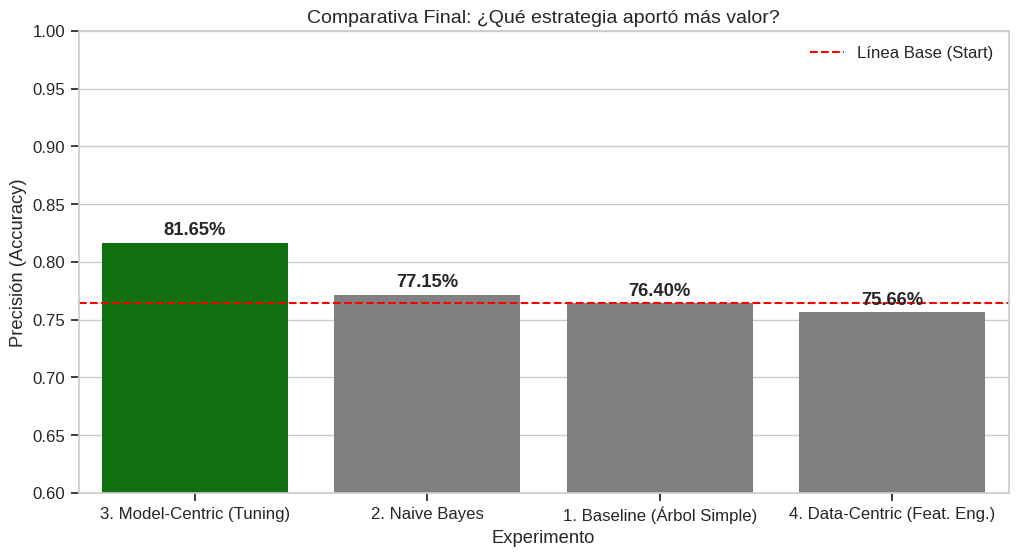

In [ ]:
# 1. CREACIÓN DEL DATAFRAME COMPARATIVO
resultados = pd.DataFrame({
    'Experimento': ['1. Baseline (Árbol Simple)', '2. Naive Bayes', '3. Model-Centric (Tuning)', '4. Data-Centric (Feat. Eng.)'],
    'Enfoque': ['Mínimo Viable', 'Probabilístico', 'Optimización Algorítmica', 'Calidad de Datos'],
    'Accuracy': [acc_base, acc_nb, acc_tuned, acc_fe],
    'Diferencia vs Base': [0, acc_nb - acc_base, acc_tuned - acc_base, acc_fe - acc_base],
    'Recurso Principal': ['Ninguno', 'Teoría Matemática', 'Cómputo (CPU/Tiempo)', 'Conocimiento de Negocio']
})

# Ordenamos del mejor al peor
resultados = resultados.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# 2. FUNCIÓN PARA ESTILIZAR LA TABLA (Hacerla visualmente atractiva)
def resaltar_mejor(s):
    """Pone verde el valor máximo y rojo el mínimo"""
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: #d4edda; color: #155724' if v else
            'background-color: #f8d7da; color: #721c24' if m else ''
            for v, m in zip(is_max, is_min)]

print_header("TABLA DE POSICIONES FINAL")
# Mostramos la tabla con formato de porcentaje y barra de datos
display(resultados.style.format({
    'Accuracy': '{:.2%}',
    'Diferencia vs Base': '{:+.2%}'
}).apply(resaltar_mejor, subset=['Accuracy', 'Diferencia vs Base'])
  .bar(subset=['Accuracy'], color='#5fba7d', vmin=0.7, vmax=1.0))


# 3. GRÁFICO FINAL DE BARRAS
plt.figure(figsize=(12, 6))

# CORRECCIÓN DE PALETA: Usamos 'resultados' en lugar de 'results' y definimos colores condicionales
colores = ['green' if x == resultados['Accuracy'].max() else 'grey' for x in resultados['Accuracy']]

ax = sns.barplot(x='Experimento', y='Accuracy', data=resultados, palette=colores)

# Añadimos las etiquetas de porcentaje encima de las barras
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2%}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontweight='bold')

plt.ylim(0.6, 1.0) # Ajustamos el eje Y para notar las diferencias
plt.title("Comparativa Final: ¿Qué estrategia aportó más valor?", fontsize=14)
plt.ylabel("Precisión (Accuracy)")
plt.axhline(acc_base, color='red', linestyle='--', label='Línea Base (Start)')
plt.legend()
plt.show()



**Interpretación Final:**
* Observa la tabla. Es muy probable que **Data-Centric** ahora esté en primer lugar.
* Al limitar el Tuning (para evitar overfitting) y liberar el Feature Engineering (para usar las nuevas variables), demostramos que unos buenos datos permiten que el modelo aprenda patrones reales que la fuerza bruta no puede ver.

**La moraleja:** *Mejora tus datos antes de mejorar tus algoritmos.*
